In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import RegularGridInterpolator
import mat73
import time

# ------------------     MATLAB STUFF  ----------------------------------
def get_matlab_variables(mat_file_path):
    variables = mat73.loadmat(mat_file_path)
    #double gets converted to np array by default
    value_func_data = variables['Vx']
    lx_data = variables['lx'] 
    tau2 = variables['tau2']

    #Deriv is cell which gets converted into list of lists
    deriv_x_data = np.array(variables['Deriv'][0])
    deriv_x_data = deriv_x_data.squeeze()
    deriv_y_data = np.array(variables['Deriv'][1])
    deriv_y_data = deriv_y_data.squeeze()
    deriv_th_data = np.array(variables['Deriv'][2])
    deriv_th_data = deriv_th_data.squeeze()

    #g is struct whic gets converted into dic
    #vs is cell which give a list
    x_coord=np.array(variables['g']['vs'][0])
    y_coord=np.array(variables['g']['vs'][1])
    th_coord=np.array(variables['g']['vs'][2])
    x_coord = x_coord.squeeze()
    y_coord = y_coord.squeeze()
    th_coord = th_coord.squeeze()

    matlab_var_dict = dict( value_func_data=value_func_data,
                            lx_data=lx_data,
                            deriv_x_data=deriv_x_data,
                            deriv_y_data=deriv_y_data,
                            deriv_th_data=deriv_th_data,
                            x_coord=x_coord,
                            y_coord=y_coord,
                            th_coord=th_coord,
                            tau2=tau2
                           )
    return matlab_var_dict

def get_value_function(matlab_var_dict):
   val_func_eval = RegularGridInterpolator(( matlab_var_dict['x_coord'], matlab_var_dict['y_coord'], matlab_var_dict['th_coord']), matlab_var_dict['value_func_data'] ,  bounds_error=False, fill_value=None)
   return val_func_eval

def get_lx_function(matlab_var_dict):
   lx_eval = RegularGridInterpolator(( matlab_var_dict['x_coord'], matlab_var_dict['y_coord']), matlab_var_dict['lx_data'] ,  bounds_error=False, fill_value=None)
   return lx_eval

def get_deriv_x_function(matlab_var_dict):
   deriv_x_eval = RegularGridInterpolator(( matlab_var_dict['x_coord'], matlab_var_dict['y_coord'], matlab_var_dict['th_coord'] ), matlab_var_dict['deriv_x_data'] ,  bounds_error=False, fill_value=None)
   return deriv_x_eval

def get_deriv_y_function(matlab_var_dict):
   deriv_y_eval = RegularGridInterpolator(( matlab_var_dict['x_coord'], matlab_var_dict['y_coord'], matlab_var_dict['th_coord'] ), matlab_var_dict['deriv_y_data'] ,  bounds_error=False, fill_value=None)
   return deriv_y_eval

def get_deriv_th_function(matlab_var_dict):
   deriv_th_eval = RegularGridInterpolator(( matlab_var_dict['x_coord'], matlab_var_dict['y_coord'], matlab_var_dict['th_coord'] ), matlab_var_dict['deriv_th_data'] ,  bounds_error=False, fill_value=None)
   return deriv_th_eval

def get_opt_control( deriv_x_fun, deriv_y_fun, deriv_th_fun, state, vMax, vMin, angleMax, u_mode = 'max'):
    # if strcmp(uMode, 'max')
    # uOpt{2} = (deriv{3}>=0)*obj.angleMax + (deriv{3}<0)*(-obj.angleMax);  %steering control
    # det1 = deriv{1} .* cos(y{3}) + deriv{2} .* sin(y{3}) + deriv{3} .* tan(uOpt{2}).*(1/obj.L);
    # uOpt{1} = (det1 >= 0) * max(obj.vRange) + (det1 < 0) * min(obj.vRange);%vel control
    x_deriv = deriv_x_fun(state)
    y_deriv = deriv_y_fun(state)
    th_deriv = deriv_th_fun(state)
    if u_mode == 'max':        
        opt_angle = angleMax * ( th_deriv >= 0 ) + (-angleMax) * ( th_deriv < 0 )
        det1 = x_deriv * np.cos(state[2]) + y_deriv * np.sin(state[2]) + th_deriv * np.tan(opt_angle)*(1/0.235) #0.235 is the wheelbase L
        opt_v = vMax * ( det1 >= 0 ) + vMin * ( det1 < 0 )
    else:
        raise NotImplementedError
    return opt_v, opt_angle

#---------------------- Load MATLAB ---------------------------------------------------------
#v1 baseline brt
matlab_var_dict= get_matlab_variables('/home/javier/jax_work/mppi/rc_car_mppi/brt_rc_wh_coarse_v1.mat')
data = matlab_var_dict['value_func_data']
data_lx = matlab_var_dict['lx_data']
val_fun = get_value_function(matlab_var_dict)
lx_fun = get_lx_function(matlab_var_dict)
deriv_x_fun = get_deriv_x_function(matlab_var_dict)
deriv_y_fun = get_deriv_y_function(matlab_var_dict)
deriv_th_fun = get_deriv_th_function(matlab_var_dict)


In [55]:
import jax
import jax.numpy as jnp
from jax import random, jit
import matplotlib.pyplot as plt
import time
import numpy as np

# Experiment Constants
DT = 0.02
L = 0.235
V_MIN = 0.5
V_MAX = 1.5
DELTA_MIN = -0.5
DELTA_MAX =  0.5

@jit
def ackerman_dynamics(state, control, dt=DT, L=L):
    x, y, theta = state
    v, delta = control
    
    x_dot = v * jnp.cos(theta)
    y_dot = v * jnp.sin(theta)
    theta_dot = v * jnp.tan(delta) * (1 / L)
    
    new_x = x + x_dot * dt
    new_y = y + y_dot * dt
    new_theta = theta + theta_dot * dt
    
    #handle the angle wrap around
    new_theta = ((new_theta + jnp.pi) % (2 * jnp.pi)) - jnp.pi
    
    return new_x, new_y, new_theta

@jit
def cost_function(states, controls, v_target=V_MAX, delta_target=0.0):
    x = states[0, :]
    v = controls[:, 0]
    delta = controls[:, 1]
    cost = jnp.sum((v - v_target) ** 2)
    cost += jnp.sum((delta - delta_target) ** 2) * 5.0
    return cost 

@jit
def simulate_ackerman(initial_state, disturbed_controls, dt=DT, L=L):
    def step(state, control):
        new_state = ackerman_dynamics(state, control, dt, L)
        return new_state, new_state
    
    # Use jax.lax.scan to iterate over the controls and accumulate the states
    _, states = jax.lax.scan(step, initial_state, disturbed_controls)
    
    # Convert states to a JAX array
    states = jnp.array(states)
    
    # Compute the cost for the entire array of states and controls
    total_cost = cost_function(states, disturbed_controls)
    
    return states, total_cost

# Vectorize the simulation function to run multiple trajectories in parallel
simulate_ackerman_parallel = jax.vmap(simulate_ackerman, in_axes=(None, 0))



# ------------------     SIMULATION INIT  ----------------------------------

# Example usage with jax.random
key = random.PRNGKey(0)

# Simulation parameters
HALLUCINATION_STEPS = 100
NUM_THREADS = 500
TEMPERATURE = 1.0
EXPERIMENT_T = 12.0
EXPERIMENT_STEPS = int(EXPERIMENT_T / DT)
INITIAL_STATE = (3.0, 0.5, 0)

#Safety filter parameters
FILTER_EXPERIMENT = True
EXPERIMENT_THRESHOLD = 0.1
FILTER_HALLUCINATIONS = False

# Data structures
state_now = INITIAL_STATE
state_history = []
control_now = (0.0, 0.0)
control_history = []
hallucination_history = []
m_t = np.zeros((EXPERIMENT_STEPS, 3))

# Generate nominal control inputs
nominal_velocities = jnp.ones(HALLUCINATION_STEPS)
nominal_steering_angles = jnp.zeros(HALLUCINATION_STEPS)
nominal_controls = jnp.stack((nominal_velocities, nominal_steering_angles), axis=1)

# ------------------     SIMULATION LOOP  ----------------------------------

for i in range(EXPERIMENT_STEPS):

    # Generate random noise for multiple trajectories
    control_noise = random.normal(key, shape=(NUM_THREADS, HALLUCINATION_STEPS, 2)) * jnp.array([0.2, 0.1])  # Adjust the scale of noise as needed

    # Combine controls and noise before passing to the simulation function, clip to valid range
    disturbed_controls = nominal_controls + control_noise
    disturbed_controls = jnp.clip(disturbed_controls, jnp.array([V_MIN, DELTA_MIN]), jnp.array([V_MAX, DELTA_MAX]))
    # grab the noise that was actually applied
    control_noise = disturbed_controls - nominal_controls    

    # Perform the simulation
    start_time = time.time()
    states_parallel, costs_parallel = simulate_ackerman_parallel(state_now, disturbed_controls)
    end_time = time.time()
    
    # Update nominal controls using the costs and noise
    weights = jnp.exp(-TEMPERATURE * (costs_parallel))
    weights = weights[:, jnp.newaxis, jnp.newaxis]  # Adjust shape for broadcasting
    nominal_controls = nominal_controls + jnp.sum(weights * control_noise, axis=0) / jnp.sum(weights)
    # clip the controls to the valid range
    nominal_controls = jnp.clip(nominal_controls, jnp.array([V_MIN, DELTA_MIN]), jnp.array([V_MAX, DELTA_MAX]))
    
    # Check value function and apply LR filter
    value_now = val_fun(state_now)
    lx_now = lx_fun(state_now[0:2])
  
    if FILTER_EXPERIMENT and value_now < EXPERIMENT_THRESHOLD:
        control_now = get_opt_control(deriv_x_fun, deriv_y_fun, deriv_th_fun, state_now, V_MAX, V_MIN, DELTA_MAX)
        m_t[i] = [0.8, 0.4, 0.4] 
    else:
        control_now = nominal_controls[0]
        #control_now = jnp.array([1.5 , 0.0])
        m_t[i] = [0.4, 0.4, 0.8] 
    
    # Apply the first control from the updated nominal controls to the system and store the new state
    state_now = ackerman_dynamics(state_now, control_now)
    state_history.append(state_now)
    control_history.append(control_now)
    hallucination_history.append(states_parallel)
    
    # Move the control sequence one step forward and maintain the last control
    nominal_controls = jnp.roll(nominal_controls, -1, axis=0)
    nominal_controls = nominal_controls.at[-1].set(nominal_controls[-2])

    # Print the elapsed time
    print(f"Elapsed time for rollouts {end_time - start_time:.4f} seconds")
    
# Print shapes of the states and costs
print("Shape of states array:", jnp.array(states_parallel).shape)
print("Shape of costs array:", jnp.array(costs_parallel).shape)

Elapsed time for rollouts 0.1711 seconds
Elapsed time for rollouts 0.1282 seconds
Elapsed time for rollouts 0.0016 seconds
Elapsed time for rollouts 0.0016 seconds
Elapsed time for rollouts 0.0015 seconds
Elapsed time for rollouts 0.0016 seconds
Elapsed time for rollouts 0.0015 seconds
Elapsed time for rollouts 0.0016 seconds
Elapsed time for rollouts 0.0015 seconds
Elapsed time for rollouts 0.0015 seconds
Elapsed time for rollouts 0.0016 seconds
Elapsed time for rollouts 0.0015 seconds
Elapsed time for rollouts 0.0015 seconds
Elapsed time for rollouts 0.0016 seconds
Elapsed time for rollouts 0.0016 seconds
Elapsed time for rollouts 0.0015 seconds
Elapsed time for rollouts 0.0015 seconds
Elapsed time for rollouts 0.0015 seconds
Elapsed time for rollouts 0.0015 seconds
Elapsed time for rollouts 0.0015 seconds
Elapsed time for rollouts 0.0015 seconds
Elapsed time for rollouts 0.0016 seconds
Elapsed time for rollouts 0.0014 seconds
Elapsed time for rollouts 0.0014 seconds
Elapsed time for

In [56]:
from ipywidgets import interact

# Assuming state_history , matlab_var_dict, data_lx, data, m_t, and list_hallucinations_at_idx are defined elsewhere in your code
state_history = np.array(state_history)
control_history = np.array(control_history)

def plot_func(idx_to_plot):
    state_plot = state_history [idx_to_plot]
    # Print the state with 2 decimals
    print('[x,y,th]')
    print(np.around(state_plot, decimals=2))
    # Get the index of the closest v and th to the state_first_fltr
    th_idx = np.argmin(np.abs(matlab_var_dict['th_coord'] - state_plot[2]))

    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(6, 18))

    ####race track#####
    data1 = data_lx
    data1 = data1.transpose()
    CP1 = ax1.contour(matlab_var_dict['x_coord'], matlab_var_dict['y_coord'], data1, 0, colors='red', linewidths=1)

    data2 = data[:, :, th_idx]  # Slice of lx
    data2 = data2.transpose()
    CP2 = ax1.contour(matlab_var_dict['x_coord'], matlab_var_dict['y_coord'], data2, 0, colors='blue', linewidths=1)

    # Grab closest theta
    th = matlab_var_dict['th_coord']
    th = th[th_idx]
    # Plot trajectory and final state
    SP1 = ax1.scatter(state_history [0:idx_to_plot, 0], state_history[0:idx_to_plot, 1], c=m_t[0:idx_to_plot], s=5, alpha=0.5) #
    SP2 = ax1.scatter(state_history [idx_to_plot, 0], state_history [idx_to_plot, 1], s=10, c=[[0.0, 0.0, 0.0]], alpha=1.0)
    # Plot arrow at final state
    ax1.arrow(state_history [idx_to_plot, 0], state_history [idx_to_plot, 1], np.cos(th) * 0.2, np.sin(th) * 0.2, head_width=0.1, head_length=0.1, fc='k', ec='k')

    # Plot the hallucinations corresponding to idx_to_plot        
    for i in range(0, len(hallucination_history[idx_to_plot]), 20):
        h = hallucination_history[idx_to_plot][i]
        ax1.plot(h[0, :], h[1, :], color='green', alpha=0.2)

    # Set x and y limits
    ax1.set_xlim([0, 6])
    ax1.set_ylim([0, 4])

    # Change aspect ratio to match the grid
    ax1.set_aspect('equal')

    ####velocity plot####
    ax2.plot(control_history[:idx_to_plot+1, 0])
    ax2.scatter(idx_to_plot, control_history[idx_to_plot, 0], s=10, c=[[0.0, 0.0, 0.0]], alpha=1.0)
    ax2.set_title('velocity control')
    ax2.set_xlabel('k')
    ax2.set_aspect(aspect=50)

    ####angle plot####
    ax3.plot(control_history[:idx_to_plot+1, 1])
    ax3.scatter(idx_to_plot, control_history[idx_to_plot, 1], s=10, c=[[0.0, 0.0, 0.0]], alpha=1.0)
    ax3.set_title('angle control')
    ax3.set_xlabel('k')
    ax3.set_aspect(aspect=50)
       
    
    plt.show()

# Use interact to create a slider for idx_to_plot
interact(plot_func, idx_to_plot=(0, len(state_history ) - 2, 1))

interactive(children=(IntSlider(value=299, description='idx_to_plot', max=598), Output()), _dom_classes=('widg…

<function __main__.plot_func(idx_to_plot)>

In [13]:
print(hallucination_history[0][0].shape)

(3, 30)


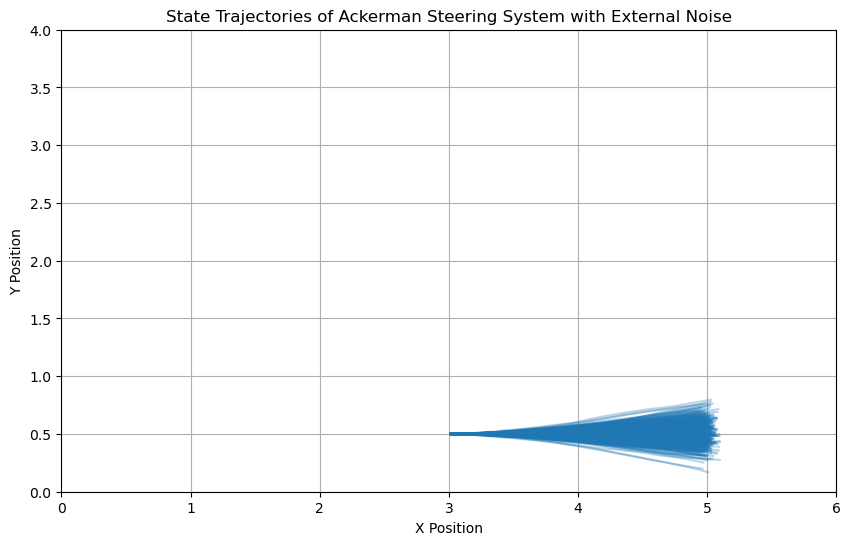

Total costs for each trajectory: [28.708733 33.958164 32.43938  27.9581   31.98818  31.071033 34.86074
 32.172417 29.97279  32.236237 30.741703 31.548075 29.878513 33.537266
 30.679539 28.673512 33.9439   32.604496 33.66948  35.773872 35.66028
 33.61075  32.730118 31.585888 33.775776 33.110443 33.353813 32.579132
 30.049686 33.75251  32.48307  30.912437 32.741447 31.970629 30.376644
 36.92285  34.00448  31.479515 36.28664  33.815903 32.405113 33.389626
 35.548836 30.98326  32.249977 30.416775 30.667864 32.180336 33.73017
 33.727634 31.734083 36.271378 30.086956 34.058273 35.84821  36.16014
 34.848602 38.150055 29.73043  33.24302  30.940866 32.45056  34.601532
 31.961443 32.86606  33.52574  32.43081  33.434967 30.886433 36.734863
 31.890417 34.114258 33.86277  33.268795 30.268942 32.145775 32.420918
 29.630354 33.974678 34.672386 32.755165 31.39524  30.571503 31.141602
 34.125286 33.17359  29.037981 32.632385 34.04003  36.42748  29.920782
 32.947407 29.428226 31.052713 35.617554 28.1418

In [31]:
# Visualize the state trajectories
hallucinations = hallucination_history[0]
plt.figure(figsize=(10, 6))
for i in range(NUM_THREADS):
    x_coords = jnp.array(hallucinations)[i, 0, :]
    y_coords = jnp.array(hallucinations)[i, 1, :]
    plt.plot(x_coords, y_coords, color='tab:blue', alpha=0.3)  
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.title('State Trajectories of Ackerman Steering System with External Noise')
plt.grid(True)
# Set x and y limits
plt.xlim([0, 6])
plt.ylim([0, 4])
plt.show()

# Print the total cost for each trajectory
print("Total costs for each trajectory:", costs_parallel)

In [ ]:
# Ensure you are in a Jupyter Notebook environment
# Use %timeit to measure the execution time
%timeit -n 20 -r 10 states_parallel = simulate_ackerman_parallel(initial_state, disturbed_controls); jax.block_until_ready(states_parallel)